<a href="https://colab.research.google.com/github/DhyeyShah794/poetry-analysis/blob/master/poetry_sentiment_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [326]:
!pip install sentence-transformers -q

In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from ast import literal_eval
from sentence_transformers import SentenceTransformer, util
import itertools
from collections import Counter

In [328]:
data = pd.read_csv('https://raw.githubusercontent.com/DhyeyShah794/poetry-analysis/master/data.csv')

In [329]:
data.head(10)

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,['acrostic']
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"['haiku', 'acrostic', 'humor']"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,['acrostic']
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"['haiku', 'acrostic']"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,['acrostic']
5,https://allpoetry.com/poem/17494723-The-Ivy-Qu...,The Ivy Queen,"Ugly\nNose of\nIvy\nQueen blew greens,\nUntil ...",['acrostic']
6,https://allpoetry.com/poem/17490821-The-Job-Se...,The Job Search,Under fluorescents\nNervousness knits\nI have ...,"['acrostic', 'hope']"
7,https://allpoetry.com/poem/17490034-Grief--Acr...,Grief (Acrostic),"Grief greatly groans, grappling injustice\nR...","['acrostic', 'pain']"
8,https://allpoetry.com/poem/17488484-Nebraska--...,Nebraska (Acrostic Poem),New days blossom with blessings\nEarly blazing...,"['acrostic', 'nature']"
9,https://allpoetry.com/poem/17487470-Reflection...,Reflection (acrostic),Remembering the sunshine days\nEffervescent me...,"['poetry', 'acrostic', 'love']"


In [330]:
data.shape

(63731, 4)

In [331]:
data.describe()

,url,title,poem,categories
count,63731,63158,63400,63731
unique,63731,58548,63205,25106
top,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,Graduation,I remember\nIt was the year\nThe grizzlies ran...,[]
freq,1,72,8,917


In [332]:
data.isnull().sum()

url             0
title         573
poem          331
categories      0
dtype: int64

In [333]:
data = data[data['poem'].notnull()]
data = data[~data['categories'].isin(['[]'])]

In [334]:
data.shape

(62524, 4)

In [335]:
data.isnull().sum()

url             0
title         521
poem            0
categories      0
dtype: int64

In [336]:
# data[data['url'].str.contains('Betweenkittensandriots')]

Text(0.5, 1.0, 'Histogram of Poem Lengths')

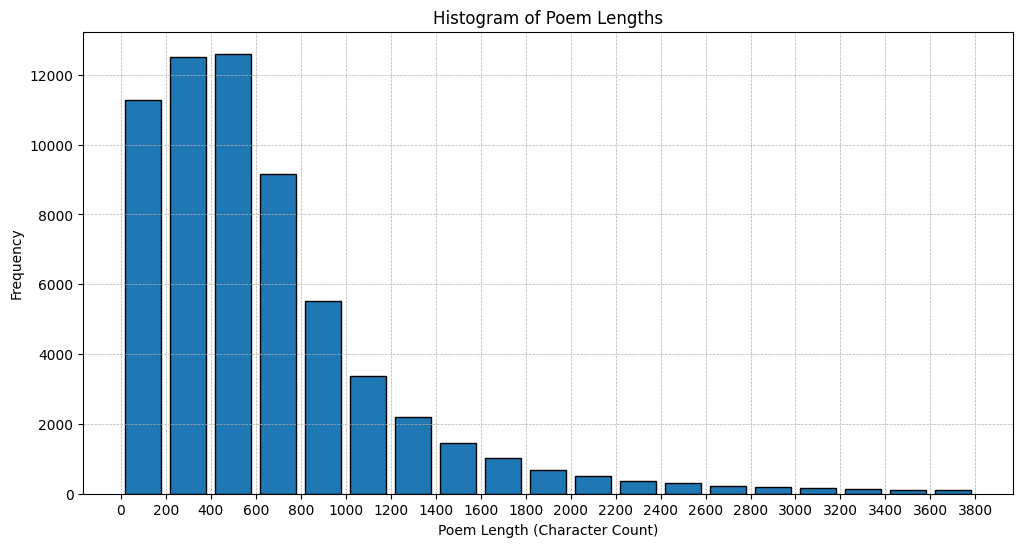

In [337]:
data['poem_length'] = data['poem'].apply(len)
intervals = [i * 200 for i in range(20)]

plt.figure(figsize=(12, 6))
plt.hist(data['poem_length'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(intervals)

plt.xlabel('Poem Length (Character Count)')
plt.ylabel('Frequency')
plt.title('Histogram of Poem Lengths')

In [338]:
def word_count(text):
  words = re.findall(r'\w+', text)
  return len(words)

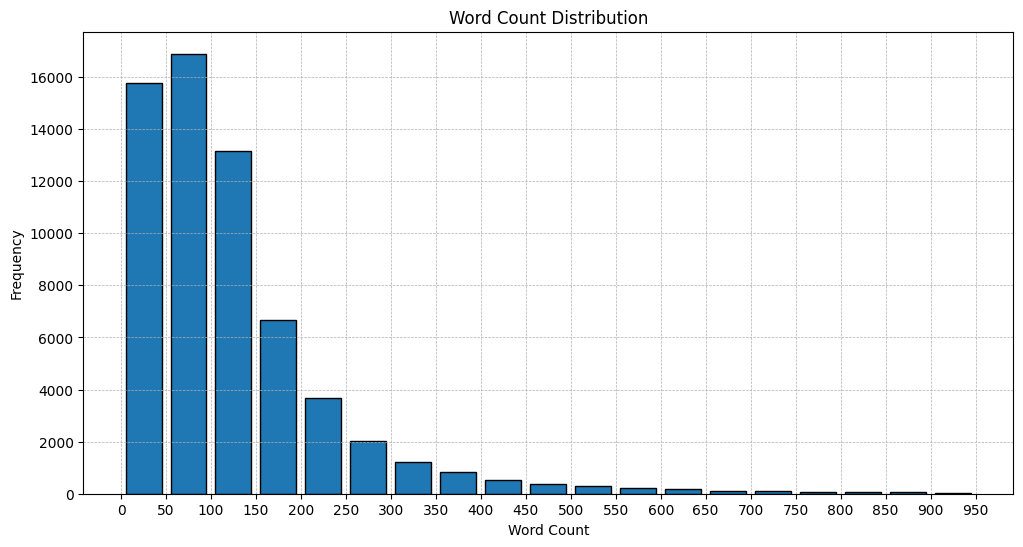

In [339]:
data['word_count'] = data['poem'].apply(word_count)
intervals = [i * 50 for i in range (20)]

plt.figure(figsize=(12, 6))
plt.hist(data['word_count'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.xticks(intervals)

plt.show()

In [340]:
data['categories'] = data['categories'].apply(literal_eval)  # To convert data types from str to list

In [341]:
unique_cats = set()

In [342]:
for cat_list in data['categories']:
  for value in cat_list:
    unique_cats.add(value)

In [343]:
unique_cats = sorted(list(unique_cats))
print(len(unique_cats))
print(f"Unique categories: {unique_cats}")

232
Unique categories: ['acrostic', 'africa', 'alone', 'america', 'angel', 'anger', 'animal', 'anniversary', 'april', 'august', 'autumn', 'baby', 'ballad', 'beach', 'beautiful', 'beauty', 'believe', 'bipolar', 'birth', 'brother', 'butterfly', 'candy', 'car', 'cat', 'change', 'chicago', 'child', 'childhood', 'children', 'chocolate', 'christian', 'christmas', 'cinderella', 'city', 'concrete', 'couplet', 'courage', 'crazy', 'culture', 'dance', 'dark', 'dark-humor', 'daughter', 'death', 'depression', 'despair', 'destiny', 'discrimination', 'dog', 'dream', 'education', 'elegy', 'epic', 'evil', 'fairy', 'faith', 'family', 'farewell', 'fate', 'father', 'fear', 'fire', 'fish', 'fishing', 'flower', 'fog', 'food', 'football', 'freedom', 'friend', 'frog', 'fun', 'funeral', 'funny', 'future', 'girl', 'god', 'golf', 'graduate', 'graduation', 'greed', 'green', 'grief', 'guitar', 'haiku', 'hair', 'happiness', 'happy', 'hate', 'heart', 'heaven', 'hero', 'history', 'holocaust', 'home', 'homework', 'hon

In [344]:
cat_freq = {}
for value in itertools.chain.from_iterable(data['categories']):
    cat_freq[value] = cat_freq.get(value, 0) + 1

In [345]:
# new = sorted(cat_dict.items(), key=lambda x: x[1])
# new = new[::-1][:n]

In [346]:
n = 25

In [347]:
counter = Counter(cat_freq)
most_freq = counter.most_common(n)
least_freq = counter.most_common()[:-n-1:-1]

In [348]:
total_count = sum(cat_freq.values())
percentages = {cat: count/total_count * 100 for cat, count in cat_freq.items()}
counter = Counter(percentages)
max_percent = counter.most_common(n)
min_percent = counter.most_common()[:-n-1:-1]

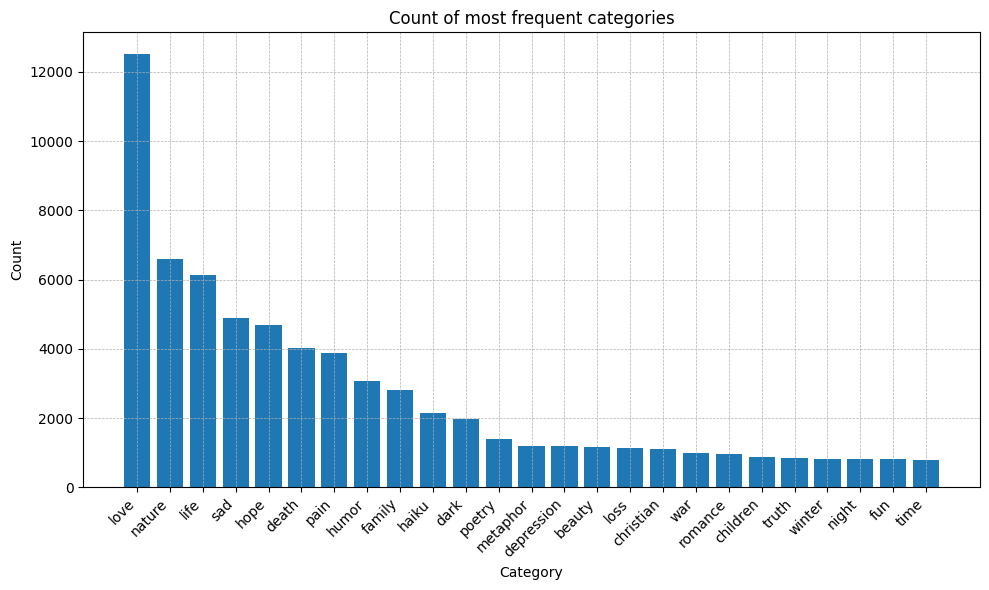

In [353]:
# Count of most frequent categories

cats, counts = zip(*most_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of most frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

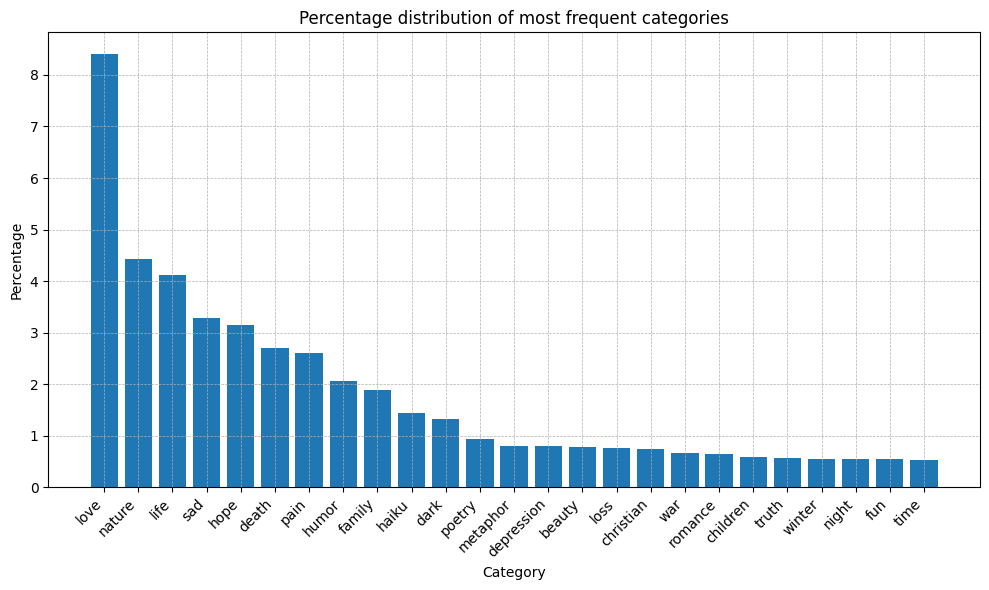

In [354]:
# Percentage distribution of most frequent categories

cats, percentages = zip(*max_percent)
plt.figure(figsize=(10, 6))
plt.bar(cats, percentages)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title(f'Percentage distribution of most frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

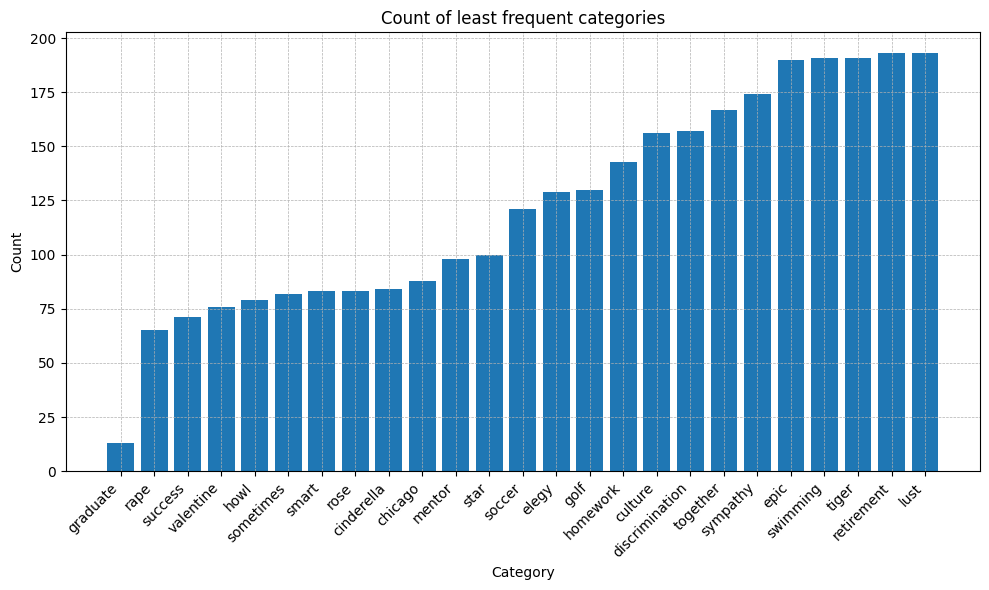

In [355]:
# Count of least frequent categories

cats, counts = zip(*least_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of least frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

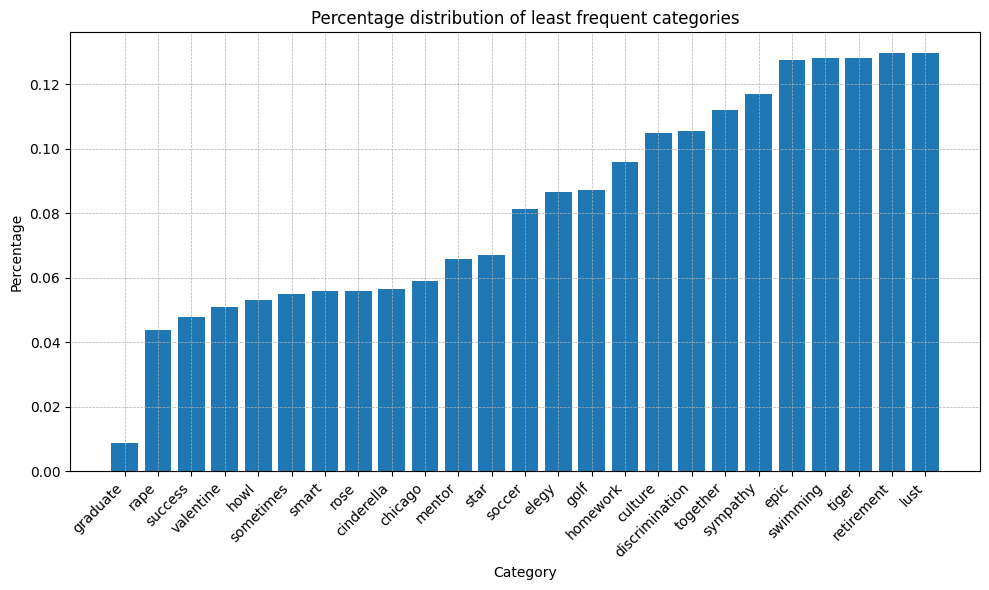

In [356]:
# Percentage distribution of least frequent categories

cats, percentages = zip(*min_percent)
plt.figure(figsize=(10, 6))
plt.bar(cats, percentages)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title(f'Percentage distribution of least frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Combining similar categories
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
pairs = list(itertools.combinations(unique_cats, 2))
cosine_scores = []
for pair in pairs:
  cat1 = pair[0]
  cat2 = pair[1]
  embeddings1 = model.encode(cat1)
  embeddings2 = model.encode(cat2)
  cosine_score = util.cos_sim(embeddings1, embeddings2)
  cosine_scores.append(cosine_score.item())

In [ ]:
cosine_scores

In [ ]:
threshold = 0.5
new = [(i, cosine_scores[i]) for i in range(len(cosine_scores)) if cosine_scores[i] >= threshold]

In [ ]:
similar_pairs = [pairs[value[0]] for value in new]
print(similar_pairs)

[('africa', 'america'), ('africa', 'world'), ('alone', 'lonely'), ('alone', 'solitude'), ('america', 'culture'), ('america', 'war'), ('america', 'world'), ('anger', 'happiness'), ('anger', 'laughter'), ('anger', 'pain'), ('anger', 'passion'), ('anger', 'sorrow'), ('animal', 'cat'), ('animal', 'dog'), ('animal', 'fish'), ('animal', 'frog'), ('animal', 'horse'), ('animal', 'hunting'), ('animal', 'snake'), ('animal', 'tiger'), ('anniversary', 'romantic'), ('anniversary', 'valentine'), ('april', 'august'), ('april', 'january'), ('april', 'july'), ('april', 'june'), ('april', 'october'), ('april', 'september'), ('april', 'spring'), ('april', 'summer'), ('april', 'today'), ('august', 'autumn'), ('august', 'january'), ('august', 'july'), ('august', 'june'), ('august', 'october'), ('august', 'september'), ('august', 'summer'), ('autumn', 'october'), ('autumn', 'rain'), ('autumn', 'september'), ('autumn', 'snow'), ('autumn', 'spring'), ('autumn', 'summer'), ('autumn', 'sunset'), ('autumn', 'win

In [ ]:
with open('similar_pairs.txt', 'w') as f:
  for pair in similar_pairs:
    f.write(f'{pair[0]}, {pair[1]}\n')